# The problem

In this assignment, we will work with a dataset of credit card users from one of Russian banks. 

One of the decisions that the bank must make when issuing a credit card is to how large a limit to provide. 

The larger the limit is, the higher is the potential loss for bank in case of default, but the higher is the potential profit if the client is good and makes a lot of transactions. So it is important to predict probability of default and credit card turnover to make the decision about the limit. 

Prediction of probability of default is the standard problem of credit scoring. We will return to it later, and in the current assignment we'll focus on predicting the credit card turnover. 

For this problem, you are given a dataset of few variables that the bank knows about its clients. It contains:

|Column|Type|Explanation|
|---|---|---|
|education|Categorical|Reported education level of the client (А - PhD, HH - several higher, H - higher, UH - unfinished higher, S - general, SS - special general, US - unfinished general)|
|income|Numeric|Reported monthly income of the client (in RUR)|
|wrk_rgn_code|Categorical|Code of the region where the client works (according to [Russian map of region codes](https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_Russia))|
|sales_channel_id|Categorical|Code of the credit card sales channel (e.g. 2 = in a branch, 6 = on the bank website, 3 = via direct sales)|
|age|Numeric|Age of the client at the moment of application|
|id|Categorical|Unique ID of the application|
|avg_monthly_turnover|Numeric| Average monthly credit card turnover (in RUR) for the first year of usage, **the target variable** |

A (randomly chosen) half of values of `avg_monthly_turnover` was dropped, so that we can use them as a test set.

The true values of the test set are hosted on Kaggle: https://www.kaggle.com/t/d07bd08bc539407c8de78c3479ed5ce9. 

After making your predictions for the test set, you can submit them to Kaggle and see how accurate they are. 

# Describing the distribution

In [1]:
!wget https://raw.githubusercontent.com/avidale/ps4ds2019/master/homework/week4/credit_card_clients_split.csv

/bin/sh: wget: command not found


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [3]:
data = pd.read_csv('credit_card_clients_split.csv')
print(data.shape) # number of rows and columns
data.head()

(270346, 7)


,education,income,wrk_rgn_code,sales_channel_id,age,id,avg_monthly_turnover
0,H,50000.0,77,2,26,86163995489,19179.7769
1,H,55000.0,77,2,33,69378053433,NaN
2,H,110000.0,77,2,23,37711561972,0.0000
3,H,150000.0,77,2,36,114399953,NaN
4,H,250000.0,77,2,30,75431117188,NaN


We already see some `NaN`s in the target columns - the values were intentionally exculded. Are there any more missing values?

In [4]:
data.isnull().mean()

education               0.0
income                  0.0
wrk_rgn_code            0.0
sales_channel_id        0.0
age                     0.0
id                      0.0
avg_monthly_turnover    0.5
dtype: float64

No, the only column with missing values is the target. 

So we can just drop the observations with missing target to obtain the clean train set. 

In [5]:
train = data.dropna().copy()
print(train.shape)

(135173, 7)


Let's start by looking at the descriptive statistics of our target.

Mean monthly turnover is ~10000 roubles (~600 shekels), the middle half of clients spends between 2000 and 12000 roubles per month. The maximum is larger by two order of magnitude. Quite asymmetric, as usual!

In [11]:
train.income.describe()

count    1.351730e+05
mean     4.727269e+04
std      9.305605e+04
min      2.196000e+03
25%      2.056700e+04
50%      3.000000e+04
75%      5.000000e+04
max      1.500000e+07
Name: income, dtype: float64

In [6]:
train.avg_monthly_turnover.describe()

count    1.351730e+05
mean     1.105290e+04
std      2.473495e+04
min      0.000000e+00
25%      1.961266e+03
50%      5.544461e+03
75%      1.197325e+04
max      2.689803e+06
Name: avg_monthly_turnover, dtype: float64

When we try to plot the histogram, this asymmetry becomes even more obvious.

It is a bad thing, because a few high-turnover outliers would strongly affect our estimates and make them irrelevant for the majority of clients.

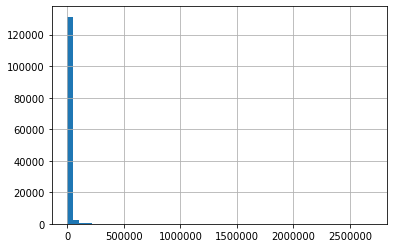

In [7]:
train.avg_monthly_turnover.hist(bins=50);

Even if we try to omit the most exteme outliers, the problem of very asymmetric distribution would remain. 

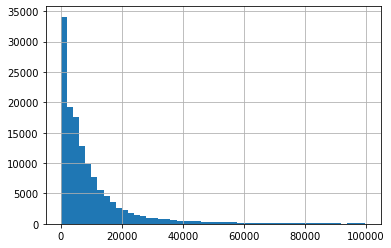

In [9]:
train.avg_monthly_turnover[train.avg_monthly_turnover < 500000].hist(bins=50);

So instead of dropping the "outliers", let's change the scale: instead of estimating turnover, we'll look at the logarithm of turnover.  

Here and below, we add 1 before taking logs, in order to avoid the infinite logarithm of zero. 

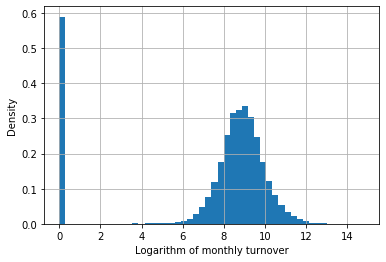

In [10]:
np.log(1 + train.avg_monthly_turnover).hist(bins=50, density=True)
plt.xlabel('Logarithm of monthly turnover');
plt.ylabel('Density');

Now we clearly see that distribution of montly turnover is a mixture of 2 distributions - a constant $0$ and someting that looks very much like lognormal. 

Therefore, we can predict turnover in two steps:
1. Predict, whether it is zero or positive
2. If it is positive, predict its value

We'll start with the second step.

# Predicting positive turnover - a numeric problem (regression)

To model the positive part of the turnover distribution, we will use the corresponding part of the dataset. 

In [12]:
positive = train[train.avg_monthly_turnover > 0].copy()

To make the distribution more symmetric, we'll keep it in the logarithmic scale. We choose the base $10$, so $10$ turns into $1$, $100$ turns into $2$, $1000$ turns into 3, and so on. 

In the logarithmic scale, median and mean are very close to each other, so the distribution seems very symmetric indeed. The skewness coefficient is a little negative, which reflects a left tail which is a little longer. But the left tail is not a problem, because the monthly turnover is at least bounded from below. 

count    111574.000000
mean          3.863752
std           0.467462
min           0.114444
25%           3.580776
50%           3.861548
75%           4.149355
max           6.429721
Name: log_turnover, dtype: float64
-0.20205827864036144


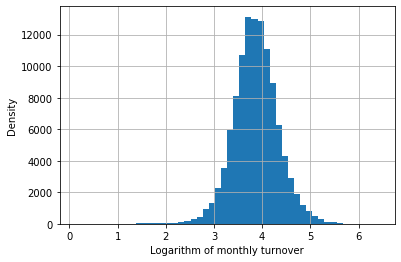

In [13]:
positive['log_turnover'] = np.log10(1 + positive.avg_monthly_turnover)
positive['log_turnover'].hist(bins=50)
plt.xlabel('Logarithm of monthly turnover')
plt.ylabel('Density')
print(positive['log_turnover'].describe())
print(positive['log_turnover'].skew())

### Predicting with a continuous feature

Our dataset contains 3 numerical variables. Let's look at the other two: income and age.

The income appears very asymmetric as well, so we'll do the same logarithmic trick again. In the log scale, distribution of income appears almost normal, but with a heavier right tail. 

Age is less asymmetric, so it is okay to keep it in original scale. 

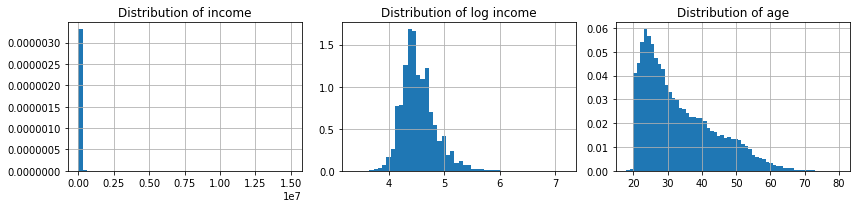

In [14]:
plt.figure(figsize=(12,3))
plt.subplot(1, 3, 1)
positive.income.hist(bins=50, density=True)
plt.title('Distribution of income')
plt.subplot(1, 3, 2)
np.log10(positive.income).hist(bins=50, density=True)
plt.title('Distribution of log income')
plt.subplot(1, 3, 3)
positive.age.hist(bins=61, density=True)
plt.title('Distribution of age')
plt.tight_layout()

In [15]:
positive['log_income'] = np.log10(1 + positive.income)

Let's estimate how closely they are related to each other using the correlation coefficient. 

In [16]:
positive[['log_turnover', 'log_income', 'age']].corr()

,log_turnover,log_income,age
log_turnover,1.000000,0.543630,0.029943
log_income,0.543630,1.000000,0.149708
age,0.029943,0.149708,1.000000


First impression: quite intuitive. Income positively affects turnover, age positively affects income, but the age almost doesn't affect turnover. 

Second impression: if the age didn't directly affect turnover, then correlation between age and turnover would be larger, because of the indirect influence: $age \rightarrow_+ income \rightarrow_+ turnover$. In this case, I would expect $corr(turnover, age)\approx corr(turnover,income)\times corr(income, age)\approx 0.54 \times 0.15 \approx 0.08$, but in fact it is only $0.03$. It means that there might be one more causality, $age \rightarrow_{-} turnover$. It is intuitive as well: old people might be on average less eager to pay with credit cards. 

In order to check this second-order intuition, we need a tool like multivariate linear regression, which we will discuss in the further lessons. But now let's concentrate on the strong dependency between income and turnover. 

Let's start with making a scatterplot of their joint distribution. 

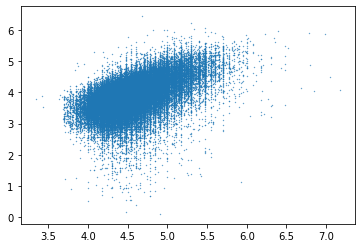

In [17]:
plt.scatter(positive.log_income, positive.log_turnover, s=0.1);

We can estimate the mean and covariance matrix for our joint distribution - using the sample mean and covariances. 

In [18]:
mean_vector = positive[['log_income', 'log_turnover']].mean()
print(mean_vector)
cov_matrix = positive[['log_income', 'log_turnover']].cov()
print(cov_matrix)

log_income      4.541194
log_turnover    3.863752
dtype: float64
              log_income  log_turnover
log_income      0.093380      0.077656
log_turnover    0.077656      0.218521


If we believed that the joint distribution of log-income and log-turnover is normal, then confidence ellipses (сontours of the joint PDF) for it would look like this. 

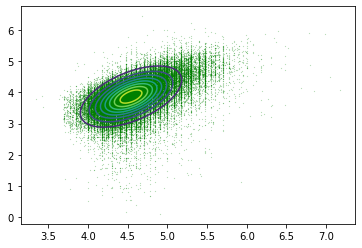

In [19]:
X, Y = np.meshgrid(
    np.linspace(*positive.log_income.quantile([0,1]).values, 1000),
    np.linspace(*positive.log_turnover.quantile([0,1]).values, 1000)
)
density = scipy.stats.multivariate_normal(
    mean=mean_vector, cov=cov_matrix).pdf(
    np.vstack([X.ravel(), Y.ravel()]).T
).reshape(X.shape)
plt.scatter(positive.log_income, positive.log_turnover, s=0.01, c='green');
CS = plt.contour(X, Y, density, levels=10)

Alternatively, we can visualize the joint density as a 3D graph

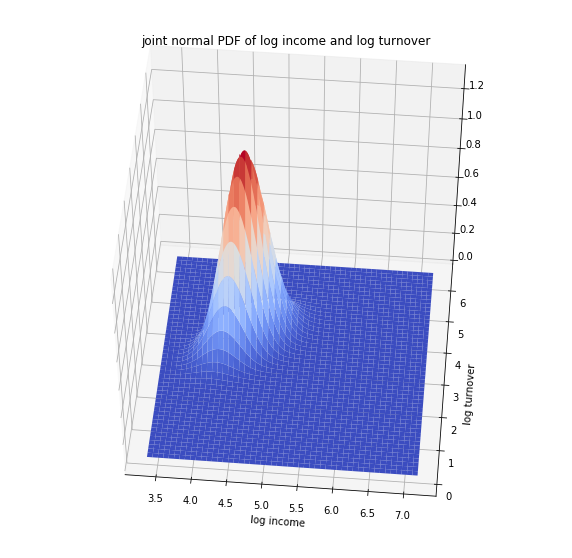

In [20]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=density, cmap=cm.coolwarm)
ax.set_xlabel('log income')
ax.set_ylabel('log turnover')
plt.title('joint normal PDF of log income and log turnover')
ax.view_init(50, -85) # you can change these angles to rotate the plot

We know that conditional joint normal distribution is also normal, and we can use this knowledge for prediction.

Now you should use the formulas of conditional normal distribution from the slides or [Wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2) to express the three parameters:
* $slope$ and $intercept$ for the expression $\mathbb{E}(\log turnover|\log income) = intercept + slope \times \log income$
* the value $Var(\log turnover | \log income)$

All these unknowns may be extracted from the mean vector and covariance matrix. However, you may want to calculate correlation and standard deviations as intermediate steps. 

In [21]:
# def get_conditional_distribution_parameters(mean_vector, cov_matrix):
#     """ Calculate parameters of conditional distribution of the second variable conditional on the first one """
#     # TODO: calculate slope, intercept and conditional variance
#     slope = ???
#     intercept = ???
#     cond_variance = ???
#     return intercept, slope, cond_variance

def get_conditional_distribution_parameters(mean_vector, cov_matrix):
    """ Calculate parameters of conditional distribution of the second variable conditional on the first one """
    # TODO: calculate slope, intercept and conditional variance
    cov = cov_matrix.iloc[0][1]
    s_income ,s_turnover = np.sqrt( cov_matrix.iloc[0][0]), np.sqrt(cov_matrix.iloc[1][1])
    r = cov/(s_income *s_turnover)
    slope =  r * s_turnover/s_income
    intercept = mean_vector[1]-mean_vector[0]*slope
    cond_variance = np.power(s_turnover,2)*(1 - np.power(r,2))
    return intercept, slope, cond_variance


# testing with an independent dataset
intercept, slope, cond_variance = get_conditional_distribution_parameters(pd.Series([7, 11]), pd.DataFrame([[1,0], [0,4]]))
assert intercept == 11
assert slope == 0
assert cond_variance == 4

# testing with an independent dataset
intercept, slope, cond_variance = get_conditional_distribution_parameters(pd.Series([4, 11]), pd.DataFrame([[1,1], [1,4]]))
assert intercept == 7
assert slope == 1
assert cond_variance == 3

intercept, slope, cond_variance = get_conditional_distribution_parameters(mean_vector, cov_matrix)

With this values, we can e.g. predict conditional mean and conditional 95% confidence interval for the log turnover. 

In [ ]:
base = np.linspace(*positive.log_income.quantile([0.0001, 0.9999]).values)
predicted_mean = base * slope + intercept
predicted_ub = predicted_mean + np.sqrt(cond_variance) * 1.96
predicted_lb = predicted_mean - np.sqrt(cond_variance) * 1.96

To check ourselves, we can also estimate conditional mean and conditional quantiles from the discretized version of income - just as sample statistics.

In [ ]:
discretized_income = positive.log_income.round(1)
grouped_quantiles = positive.log_turnover.groupby(discretized_income).quantile([0.025, 0.5, 0.975]).unstack()

We can see that for most of the domain mean and quantiles are predicted correctly. There are some problems for high-income clients, but their fraction is relatively low. So this model seems a good first approximation. 

In [ ]:
plt.scatter(positive.log_income, positive.log_turnover, s=0.1);
grouped_quantiles.plot(color='green', ax=plt.gca());
plt.plot(base, predicted_ub, color='k', lw=1)
plt.plot(base, predicted_lb, color='k', lw=1)
plt.plot(base, predicted_mean, color='k');

In [ ]:
(positive.log_income > 5.5).mean()

We can now estimate the relative improvement in precision that our model has. 

It can be done by comparing the conditional variance with the unconditiona. 

In [ ]:
cond_variance / cov_matrix['log_turnover']['log_turnover']

The variance of log_turnover conditional on income is 70% of the unconditional variance. 

It means that prediction of our joint normal model is 30% more precise than just predicting the unconditional mean.

That's not very much, but it is a good beginning. 

### Predicting with a discrete feature 

Prediction based on a discrete feature is much simpler: we can just estimate distribution separately for each group.



In [ ]:
for cat_variable in ['education', 'sales_channel_id', 'wrk_rgn_code']:
    positive.boxplot(column='log_turnover', by=cat_variable);
    plt.title('')
    plt.ylabel('Log of turnover');

From this pictures, we can clearly see that education does affect credict card turnover: e.g. clients with academic deegrees tend to spend more than average. It might be explained by the direct ifnluence of academic degree on client behaviour, but it may just mean that the clients with high education earn more, so they spend more.  

Sales channel id and region code also seem to be not completely independent of turnover, but the boxplots don't give us clear answers about the degree of this dependency. So let us focus only on education.  

In [ ]:
mean_by_education = positive.groupby('education').log_turnover.mean()
print(mean_by_education)

We can use this to predict turnover for all observations, based only on education. 

In [ ]:
prediction_by_education = mean_by_education.loc[positive.education]
prediction_by_education.index = positive.index

We can also compare the variance of error of such prediction with the variance of targer variable itself. 

We see that the model based on education reduces the variance only by 7.5%. So this feature seems to be far less useful than income. 

In [ ]:
print((positive.log_turnover - prediction_by_education).var() / positive.log_turnover.var())

# Predicting zero turnover - a categorical problem (classification)

We now have some ideas how to predict turnover when it is positive. But how to predict the fact that turnover is 0?

Let's create a binary variable and see how it depends on the other variables in the dataset. 

In [ ]:
train['turnover_is_positive'] = (train.avg_monthly_turnover > 0).astype(int)
print(train['turnover_is_positive'].mean())

For example, we can plot distribution of (log) income conditional on this binary variable.

In [ ]:
bins = np.linspace(np.log10(train.income.min()), np.log10(train.income.max()))
np.log10(train[train.turnover_is_positive == 1].income).hist(density=True, bins=bins)
np.log10(train[train.turnover_is_positive == 0].income).hist(density=True, bins=bins, alpha=0.5)
plt.legend(['positive turnover', 'zero turnover'])
plt.title('Histogram of log income conditional on zero or positive turnover');

Alas, it seems that income is almost independent from binary turnover, so it's not a very useful feature. 

The age seems more useful: the fraction of older clients is higher among those who don't use the card. 

In [ ]:
bins = np.linspace(train.age.min(), train.age.max()+1, num=65)
train[train.turnover_is_positive == 1].age.hist(density=True, bins=bins)
train[train.turnover_is_positive == 0].age.hist(density=True, bins=bins, alpha=0.5)
plt.legend(['positive turnover', 'zero turnover'])
plt.title('Histogram of age conditional on zero or positive turnover');

With categorical variables, it's simpler to estimate how strongly they affect our target. We can just directly estimate probabilities of the target being one, conditional on the other variable. If they are independent, these conditional probabilities should all be identical. 

Dependency on education is not very strong, but it has some interesting facts: clients with unfinished higher education have positive turnover more often than any other group. Maybe, the same personal trait makes people drop out of universities and actively use credit cards. 

In [ ]:
# here we apply the function len to calculate the number of observaions, and mean - to calculate the mean of the binary variable
train.groupby('education').turnover_is_positive.aggregate([len, np.mean])

Dependency on the channel id, however, is much stronger. Almost all the clients who filled the application in the Internet, have positive turnover. However, almost 30% of clients who obtained the card through direct sales, don't use it. 

In [ ]:
train.groupby('sales_channel_id').turnover_is_positive.aggregate([len, np.mean])

Let's use this table as our basic model for predicting probability that the client will use the card. 

In [ ]:
positive_turnover_by_channel = train.groupby('sales_channel_id').turnover_is_positive.mean()
print(positive_turnover_by_channel)

# Compiling the total prediction

Now we have some models for probability of having positive turnover, and for mean value of turnover conditional on the fact that it is positive. 

We can thus express the expected value of the logarithmic turnover with condtional expectations, as 

$$\mathbb{E}(target|data) = P(target=0|data) \times 0  + P(target > 0| data) \times \mathbb{E}(target|target > 0, data)$$

In [ ]:
data['probability_of_positive_turnover'] = positive_turnover_by_channel.loc[data.sales_channel_id].values

In [ ]:
data['mean_log_turnover_if_positive'] = intercept + np.log10(1 + data.income) * slope

In [ ]:
data['mean_log_turnover'] = data['probability_of_positive_turnover'] * data['mean_log_turnover_if_positive'] 

On the training set, mean squared error of our prediction is 2.20. That's a lot.

In [ ]:
np.mean((data['mean_log_turnover'] - np.log10(1+data.avg_monthly_turnover))**2)

But it is somehow less than if we just predicted a constant turnover for all clients. 

In [ ]:
np.mean((np.mean(np.log10(1+data.avg_monthly_turnover)) - np.log10(1+data.avg_monthly_turnover))**2)

After making this prediction, we transform it back into linear scale, so that it is expressed in roubles.

In [ ]:
data['predicted_turnover'] = 10 ** data['mean_log_turnover'] 

Just a quick look at the predictions. The distribution seems ok.

In [ ]:
data['predicted_turnover'].describe()

### Submitting the prediction to Kaggle

Now we can submit our prediction to Kaggle and see how it performs on the test set. 

In [ ]:
submission = data.loc[data.avg_monthly_turnover.isnull(), ['id', 'predicted_turnover']].copy()

To upload this prediction, we need to rename its columns, to be consistent with the requirements in https://www.kaggle.com/c/y-data-ps4ds-2019-turnover/overview/evaluation

In [ ]:
submission.columns = ['id', 'avg_monthly_turnover']
submission.to_csv('first_model.csv', index=None)

Now you can take this file and upload it to https://www.kaggle.com/c/y-data-ps4ds-2019-turnover/submit.

Make sure that you have followed the invite link first: https://www.kaggle.com/t/d07bd08bc539407c8de78c3479ed5ce9

After completing this notebook and submitting the baseline solution, you now can apply any your knowledge to try to improve its quality. 

If you go into this seriously, you are advised to use cross validation to estimate the prediction quality of your models, because the daily number of submissions to Kaggle is limited, and with cross validation you have less chance of overfitting. 

Have fun!